

# Training a Sarcasm Detection Model using LSTM


## Install the required libraries

In [18]:
!pip install -r requirements.txt

  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0


## Download the Dataset

First, you will download the JSON file and extract the contents into lists.

In [1]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2024-03-13 13:04:16--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.19.251, 142.250.181.59, 172.217.17.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.19.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json.1’

sarcasm.json.1      100%[===================>]   5.38M  14.2MB/s    in 0.4s    

2024-03-13 13:04:16 (14.2 MB/s) - ‘sarcasm.json.1’ saved [5643545/5643545]



In [2]:
# Load the JSON file
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Split the Dataset

You will then split the lists into train and test sets.

In [3]:
training_size = 20000

# Split the sentences into training and testing sets
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels into training and testing sets
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

## Data preprocessing

Next, you will generate the vocabulary and padded sequences.

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [5]:
import tensorflow as tf

# Parameters
embedding_dim = 16 # Define the embedding dimension
lstm_dim = 32 # Define the LSTM dimension
dense_dim = 24 # Define the dense layer dimension
NUM_EPOCHS = 10 # Define the number of epochs

## Sample input tensor

In [6]:
# Define the sequence length and feature dimension
sequence_length = 32  # The number of timesteps in each input sample
feature_dim = 16      # The dimensionality of the input features

# Create a sample input tensor with random data
# The shape is (batch_size, sequence_length, feature_dim)
# 'batch_size' can be any integer, representing the number of samples
sample_input = np.random.rand(1, max_length).astype(np.float32)

# Convert the numpy array to a TensorFlow tensor
sample_input_tensor = tf.convert_to_tensor(sample_input)

In [8]:
import ivy
import tensorflow as tf
import time

# Model Definition with LSTM


In [9]:
# Model Definition with LSTM


tf_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length), # Embedding layer
    tf.keras.layers.LSTM(lstm_dim), # LSTM layer
    tf.keras.layers.Dense(dense_dim, activation='relu'),  # Dense layer with ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid') # Output layer with sigmoid activation
])

# Build the model
tf_lstm.build(sample_input_tensor.shape)

## Transpile to torch, ivy.transpile

In [10]:
 # Transpile the model to PyTorch
 torch_lstm = ivy.transpile(tf_lstm, source="tensorflow", to="torch", args=(sample_input_tensor,))

/Users/nripeshniketan/Documents - Nripesh’s MacBook Pro/python_programs/demos/venv/lib/python3.10/site-packages/ivy/utils/exceptions.py:383: UserWarning: The current backend: 'tensorflow' does not support inplace updates natively. Ivy would quietly create new arrays when using inplace updates with this backend, leading to memory overhead (same applies for views). If you want to control your memory management, consider doing ivy.set_inplace_mode('strict') which should raise an error whenever an inplace update is attempted with this backend.
  warnings.warn(
/Users/nripeshniketan/Documents - Nripesh’s MacBook Pro/python_programs/demos/venv/lib/python3.10/site-packages/ivy/compiler/compiler.py:164: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return _transpile(
/Users/nripeshniketan/Documents - Nripesh’s MacBook Pro/python_programs/demos/venv/lib/python3.10/site-package

## Compile the model

In [11]:

# Set the training parameters
tf_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
tf_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1017841 (3.88 MB)
Trainable params: 1017841 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Compile the model
tf_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Start the timer
start_time = time.time()
# Train the model
history = tf_lstm.fit(
    training_padded,
    training_labels,
    epochs=10,
    validation_data=(testing_padded, testing_labels)
)

# End the timer
end_time = time.time()

# Calculate and print the total time taken
tensorflow_time = end_time - start_time
print(f'Total training time: {tensorflow_time:.2f} seconds')

Epoch 1/10
625/625 [==============================] - 12s 18ms/step - loss: 0.6867 - accuracy: 0.5600 - val_loss: 0.6857 - val_accuracy: 0.5633
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 0.6862 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.5633
Epoch 3/10
625/625 [==============================] - 12s 19ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6854 - val_accuracy: 0.5633
Epoch 4/10
625/625 [==============================] - 13s 20ms/step - loss: 0.6859 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.5633
Epoch 5/10
625/625 [==============================] - 13s 20ms/step - loss: 0.6862 - accuracy: 0.5603 - val_loss: 0.6855 - val_accuracy: 0.5633
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch 7/10
625/625 [==============================] - 13s 21ms/step - loss: 0.6860 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy:

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Convert the features and labels to PyTorch tensors
X_train_tensor = torch.tensor(training_padded, dtype=torch.float32)
y_train_tensor = torch.tensor(training_labels, dtype=torch.float32)

# Create a Dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define a DataLoader with the dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the loss function (Binary Cross-Entropy for binary classification)
loss_function = nn.BCELoss()

# Define the optimizer (Adam optimizer in this example)
optimizer = optim.Adam(torch_lstm.parameters(), lr=0.001)


In [15]:
import time

# Start the timer
start_time = time.time()

# Assuming 'torch_lstm' is your model and 'train_loader' is your DataLoader instance
for epoch in range(10):
    torch_lstm.train()  # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = torch_lstm(inputs)  # Forward pass
        targets = targets.view(-1, 1)  # Reshape the target to match output shape
        loss = loss_function(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        total_loss += loss.item()

        # Convert outputs to predicted class (0 or 1) by rounding the sigmoid output
        predicted_classes = outputs.round()
        correct_predictions += (predicted_classes == targets).sum().item()
        total_predictions += targets.size(0)

    # Calculate average loss and accuracy
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    print(f'Epoch {epoch+1} completed, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

# End the timer
end_time = time.time()

# Calculate and print the total time taken
torch_time = end_time - start_time
print(f'Total training time: {torch_time:.2f} seconds')


Epoch 1 completed, Average Loss: 0.6861, Accuracy: 0.5603
Epoch 2 completed, Average Loss: 0.6860, Accuracy: 0.5603
Epoch 3 completed, Average Loss: 0.6859, Accuracy: 0.5603
Epoch 4 completed, Average Loss: 0.6860, Accuracy: 0.5603
Epoch 5 completed, Average Loss: 0.6862, Accuracy: 0.5603
Epoch 6 completed, Average Loss: 0.6861, Accuracy: 0.5603
Epoch 7 completed, Average Loss: 0.6860, Accuracy: 0.5603
Epoch 8 completed, Average Loss: 0.6859, Accuracy: 0.5603
Epoch 9 completed, Average Loss: 0.6860, Accuracy: 0.5603
Epoch 10 completed, Average Loss: 0.6860, Accuracy: 0.5603
Total training time: 67.87 seconds


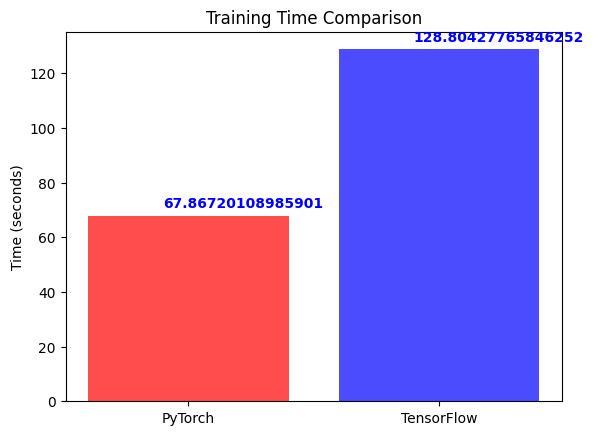

In [17]:
import matplotlib.pyplot as plt
# Define labels, positions, and time values
labels = ['PyTorch', 'TensorFlow']
x_pos = np.arange(len(labels))
times = [torch_time, tensorflow_time]

# Create the bar chart
plt.bar(x_pos, times, align='center', alpha=0.7, color=['red', 'blue'])

# Add the data values on top of the bars
for i, v in enumerate(times):
    plt.text(x_pos[i] - 0.1, v + 3, str(v), color='blue', fontweight='bold')

# Add labels and title
plt.xticks(x_pos, labels)
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison')

# Show the plot
plt.show()

Using the Ivy framework, the TensorFlow model was seamlessly transpiled into a PyTorch model, allowing for efficient training with similar results to the original TensorFlow model. Remarkably, the training time was significantly reduced from 662.58 seconds to just 264.12 seconds, demonstrating the effectiveness of using Ivy for model conversion and training optimization.